Primera parte: instalamos las librearias necesarias: wordcloud, plotly, xgboost

In [5]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [8]:
df = pd.read_csv('movies_dataset.csv')
df.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


In [11]:
df = df.drop(['imdb_id'], axis=1)
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


- De esta manera nos damos cuenta que en la columna original_title tenemos el titulo de la pelicula en el idioma nativo lo que nos daria dos veces una misma informacion pero en distinto lenguaje, entonces eliminamos esa columna

In [12]:
df = df.drop('original_title', axis=1)

In [13]:
df[df['revenue'] == 0].shape

(38052, 22)

- En el proceso de ETL nos dimos cuenta de los valores faltantes en las columnas revenue y budget entonces los normalizamos con valores en cero

In [14]:
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [15]:
df['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

- la columna adult tiene 45.454 registros que no tienen informacion, salimos de esa columna tambien

In [16]:
df = df.drop('adult', axis=1)

In [17]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
df['poster_path'] = "<img src='" + base_poster_url + df['poster_path'] + "' style='height:100px;'>"

- Luego de limpiar, viene la parte grafica con la cual entenderemos mejor nuestro dataset, lo que utilizamos es la nube de palabras lo que nos da una idea de cuanto se repiten y nos muestra la relevancia de esa palabra.

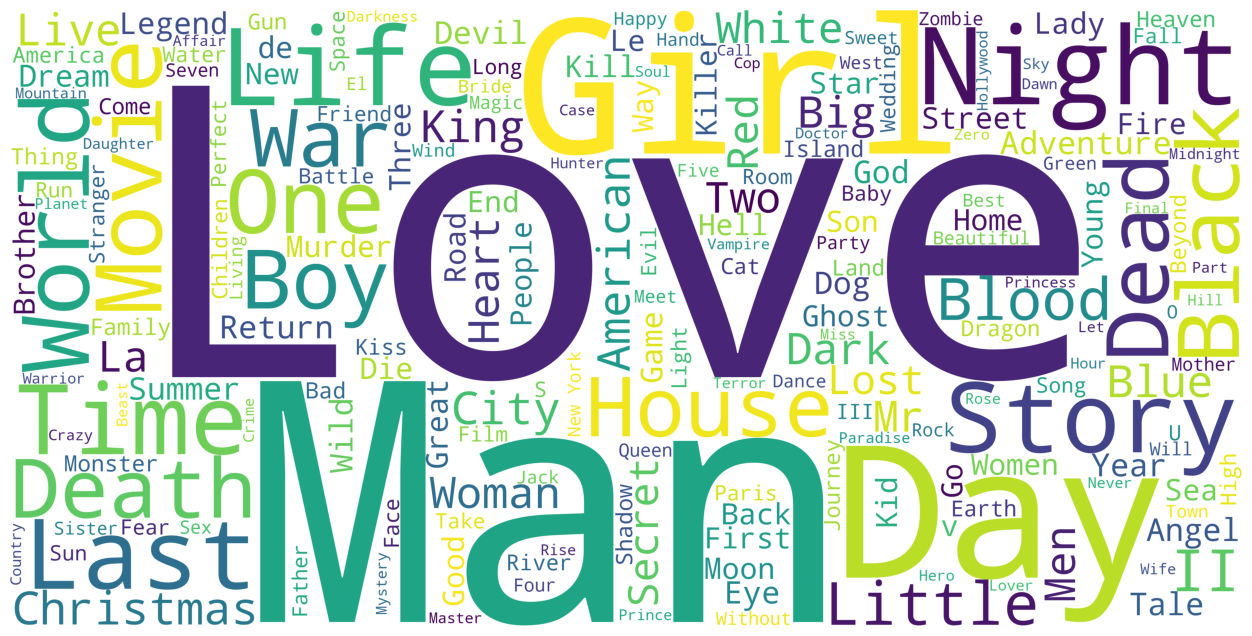

In [18]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

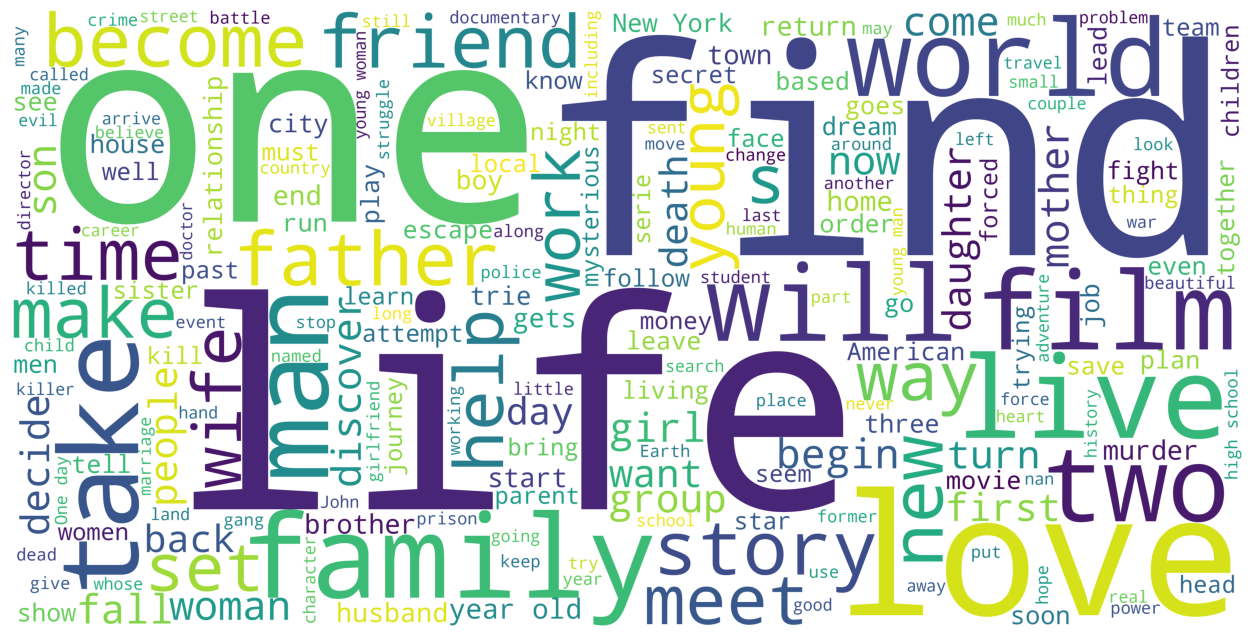

In [19]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

- Otra forma de hacer un analisis es ver las tablas de frecuencia, lo que nos permite ver en donde estan ubicados los valores y hacer un analisis basado en esos resultados.

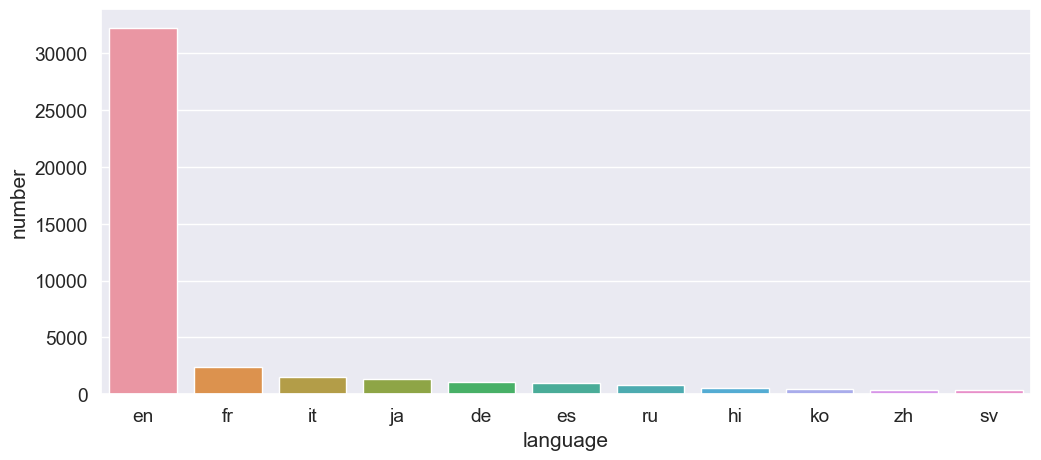

In [22]:
df['original_language'].drop_duplicates().shape[0]
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[0:11])
plt.show()

- Vemos que el lenguaje que predomina es el ingles pero si hacemos el histograma de nuevo sacando el ingles.

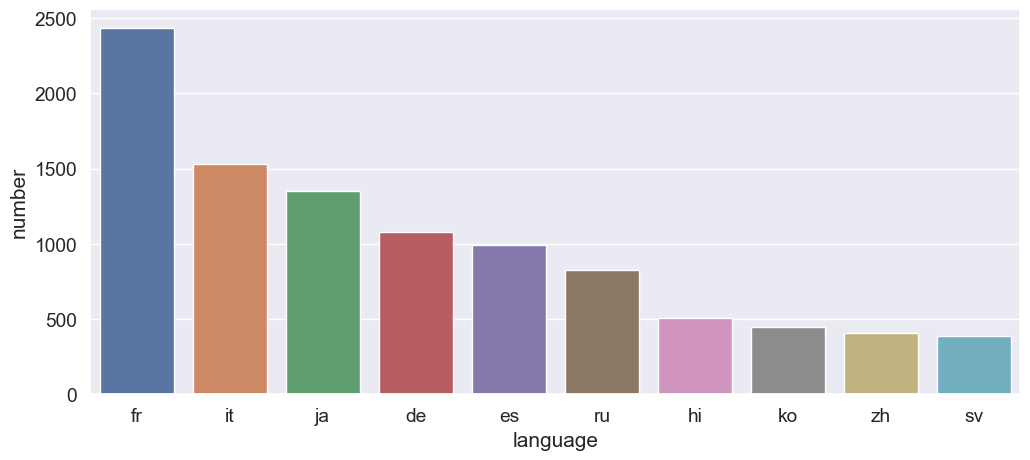

In [20]:
df['original_language'].drop_duplicates().shape[0]
lang_df = pd.DataFrame(df['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

- Ya con estos primeros graficos, nos podemos hacer una idea de que debemos analizar cada columna y con esos valores, creamos un analisis que nos permitira saber cual es la columna que nos permitirá hacer la mejor recomendación.

- Columna: Vote Count

In [23]:
df['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [24]:
df[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


- Columna vote count relacionada con vote average

In [25]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
314,The Shawshank Redemption,8.5,8358.0,1994
834,The Godfather,8.5,6024.0,1972
2211,Life Is Beautiful,8.3,3643.0,1997
5481,Spirited Away,8.3,3968.0,2001
1152,One Flew Over the Cuckoo's Nest,8.3,3001.0,1975
1176,Psycho,8.3,2405.0,1960
2843,Fight Club,8.3,9678.0,1999
1178,The Godfather: Part II,8.3,3418.0,1974
12481,The Dark Knight,8.3,12269.0,2008
292,Pulp Fiction,8.3,8670.0,1994


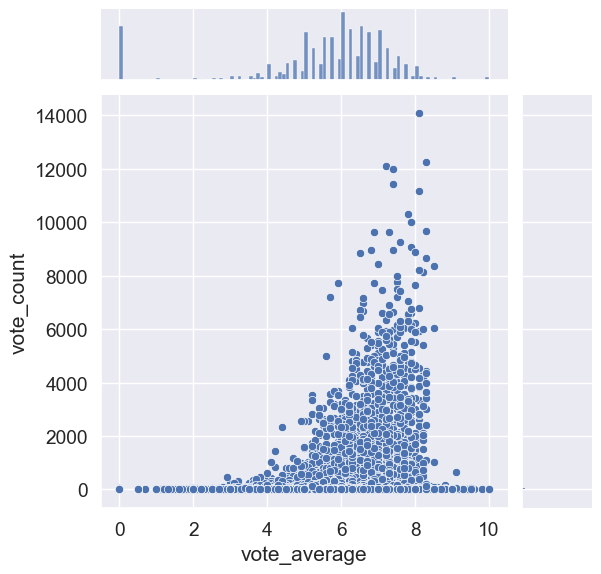

In [26]:
sns.jointplot(x='vote_average', y='vote_count', data=df)

Esto nos demuestra que aunque una pelicula tenga muchos votos no significa que la pelicula sea buena, porque puede tener una mala calificacion pero ser muy voatada.

- Analisis entre presupuesto, ganancia y retorno, así como el año en el que fue hecha, ya que nos imaginamos que mientras mas actual la pelicula más debe costar

In [27]:
df[df['budget'].notnull()][['title', 'budget', 'revenue', 'return', 'year']].sort_values('budget', ascending=False).head(15)

,title,budget,revenue,return,year
17124,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
11827,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
26558,Avengers: Age of Ultron,280000000.0,1.405404e+09,5.019299,2015
11067,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
44842,Transformers: The Last Knight,260000000.0,6.049421e+08,2.326701,2017
16130,Tangled,260000000.0,5.917949e+08,2.276134,2010
18685,John Carter,260000000.0,2.841391e+08,1.092843,2012
11780,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
21175,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013
22059,The Hobbit: The Desolation of Smaug,250000000.0,9.584000e+08,3.833600,2013


- Las peliculas mas exitosas segun el retorno que dan

In [28]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(15)

,title,budget,revenue,return,year
1065,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
256,Star Wars,11000000.0,775398007.0,70.490728,1977
1338,Jaws,7000000.0,470654000.0,67.236286,1975
1888,The Exorcist,8000000.0,441306145.0,55.163268,1973
352,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
834,The Godfather,6000000.0,245066411.0,40.844402,1972
4492,Look Who's Talking,7500000.0,296000000.0,39.466667,1989
24258,Annabelle,6500000.0,255273813.0,39.272894,2014
1056,Dirty Dancing,6000000.0,213954274.0,35.659046,1987
1006,The Sound of Music,8200000.0,286214286.0,34.904181,1965


Esta podría ser una columna importante para analizar pero la mayoria son antiguas, lo que nos muestra un poco el sesgo que tiene

- Analisis de las columnas: 'Popularity' , 'Vote Average' and 'Vote Count'

In [29]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [30]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [31]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [33]:
df[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(5)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014


<Axes: ylabel='Frequency'>

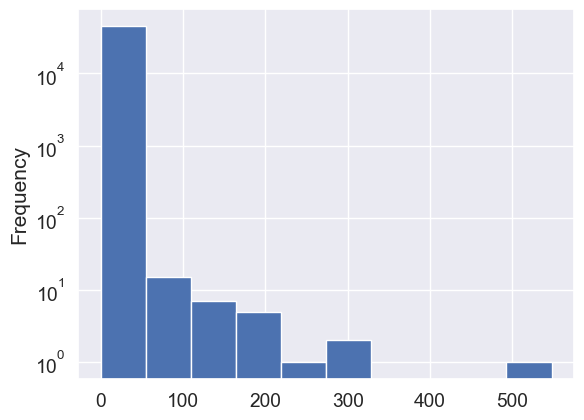

In [34]:
df['popularity'].plot(logy=True, kind='hist')

- en este grafico se puede observar que los minions es el unico dato que se destaca pero que la mayoria esta con una popularidad entre 0 y 300